# OLIMPIJSKE MEDALJE

Avtorji: Andrej Skočir, Anton Martin Turk, Miha Kavs

Šolsko leto: 2023/24

Za uporabo dokumenta potrebujemo naložiti:\
scikit-learn\
statsmodels\
pandas\
numpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

Žačnemo s tem, da preberemo podatke z uporabo pandas.

In [2]:
df = pd.read_csv('podatki/olympic_medals.csv')
df_population = pd.read_csv('podatki/countries-table.csv')

### 1. Koliko različnih disciplin je bilo skozi leta?

In [3]:
stevilo_disciplin = df['Discipline'].nunique()
print("Število razičnih disciplin:", stevilo_disciplin)

Število razičnih disciplin: 82


Koliko od teh je na poletni izvedbi in koliko na zimski?

In [4]:
# Preštejemo število edinstvenih disciplin za poletne igre
stevilo_poletnih_disciplin = df[df['Olympic_season'] == 'summer']['Discipline'].nunique()

# Preštejemo število edinstvenih disciplin za zimske igre
stevilo_zimskih_disciplin = df[df['Olympic_season'] == 'winter']['Discipline'].nunique()

print("Poletne:", stevilo_poletnih_disciplin)
print("Zimske:", stevilo_zimskih_disciplin)
print("Skupaj:", stevilo_poletnih_disciplin + stevilo_zimskih_disciplin)

Poletne: 68
Zimske: 17
Skupaj: 85


Če smo pozorni opazimo nekaj čudnega. Zgoraj smo dobili rezultat 82 različnih disciplin tukaj pa 68 poletnih in 17 zimskih kar se sešteje v 85. Zakaj nastane ta razlika treh disciplin?</br>
Poglejmo če so se kakšne discipline pojavile tako na poletnih in zimskih igrah.

In [5]:

poletne_discipline = set(df[df['Olympic_season'] == 'summer']['Discipline'].unique())

zimske_discipline = set(df[df['Olympic_season'] == 'winter']['Discipline'].unique())

# Poiščemo presek med množico disciplin za poletne in zimske igre
discipline_v_obeh = poletne_discipline.intersection(zimske_discipline)
discipline_v_obeh

{'Alpinism', 'Figure Skating', 'Ice Hockey'}

Alpinizem, umetnostno drsanje in hokej na ledu so takšne discipline, ki so se pojavile na obeh izvedbah.</br> Poglejmo si en primer:

In [6]:
# Izberemo primere, ki vsebujejo discipline, ki se pojavljajo tako na poletnih kot tudi na zimskih igrah
primeri_v_obeh = df[df['Discipline']== 'Ice Hockey']
primeri_v_obeh.head(6)

,Olympiad,Discipline,Event,Winner,Medal_type,Olympic_city,Olympic_year,Olympic_season,Gender,Code,Committee,Committee_type
1568,Antwerpen 1920,Ice Hockey,"Ice Hockey, Men",Czechoslovakia,Bronze,Antwerp,1920,summer,Men,TCH,Czechoslovakia,Former committee
1569,Antwerpen 1920,Ice Hockey,"Ice Hockey, Men",Canada,Gold,Antwerp,1920,summer,Men,CAN,Canada,Country
1570,Antwerpen 1920,Ice Hockey,"Ice Hockey, Men",United States,Silver,Antwerp,1920,summer,Men,USA,United States,Country
16938,Chamonix 1924,Ice Hockey,"Ice Hockey, Men",Great Britain,Bronze,Chamonix,1924,winter,Men,GBR,Great Britain,Country
16939,Chamonix 1924,Ice Hockey,"Ice Hockey, Men",Canada,Gold,Chamonix,1924,winter,Men,CAN,Canada,Country
16940,Chamonix 1924,Ice Hockey,"Ice Hockey, Men",United States,Silver,Chamonix,1924,winter,Men,USA,United States,Country


Kot lahko sami opazite, stolpec 'Discipline' je v vseh primerih 'Ice Hockey', medtem ko je stolpec 'Olympic_season' v treh zapisih 'summer', v treh pa 'winter'.

### 2. Število tekmovanj glede na disciplino

In [7]:

tekmovanja_glede_na_disciplino = df['Discipline'].value_counts()

print("Število tekmovanj glede na disciplino:")
print(tekmovanja_glede_na_disciplino)

Število tekmovanj glede na disciplino:
Discipline
Athletics              3082
Swimming               1762
Wrestling              1356
Artistic Gymnastics    1010
Boxing                  996
                       ... 
Equestrian Driving        3
Motorboating              3
Cricket                   2
Aeronautics               1
Basque pelota             1
Name: count, Length: 82, dtype: int64


Ker je disciplin 82, si je težko podatke predstavljati tekstovno.</br>
Zato si poglejmo histogram:

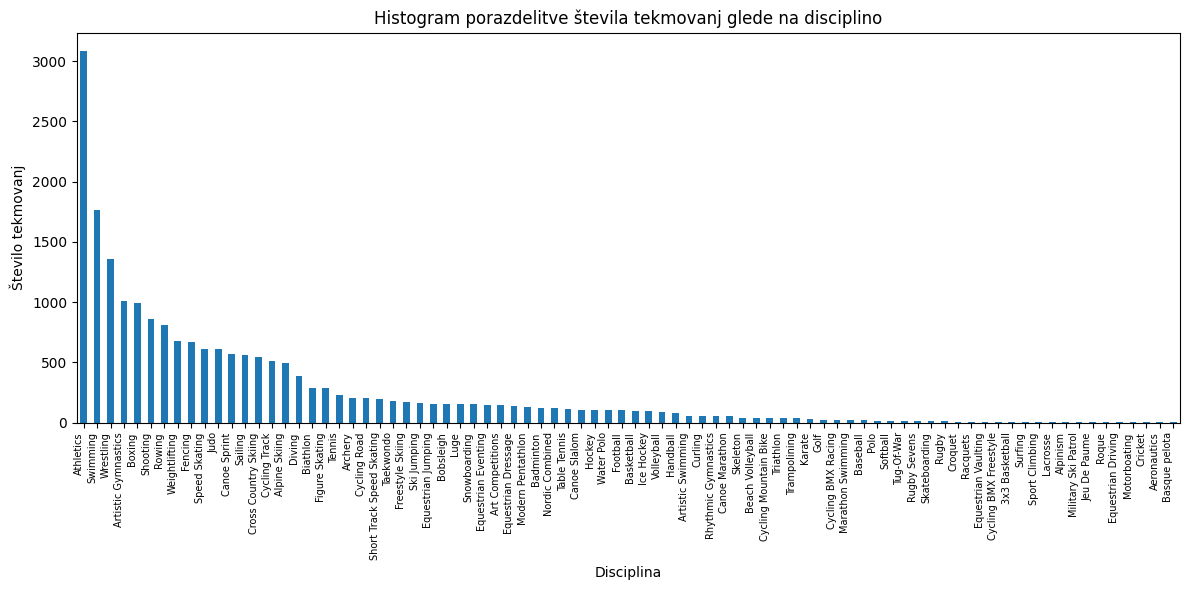

In [8]:

plt.figure(figsize=(12, 6))
tekmovanja_glede_na_disciplino.plot(kind='bar')
plt.title('Histogram porazdelitve števila tekmovanj glede na disciplino')
plt.xlabel('Disciplina')
plt.ylabel('Število tekmovanj')
plt.xticks(ha='right', fontsize=7)
plt.tight_layout()
plt.show()

Opazimo, da ima atletika daleč največ tekmovanj na disciplino, kar čez 3000, naslednje je plavanje in nato rokoborba.

### 3. Najuspešnejše države v ekipnih tekmovanjih

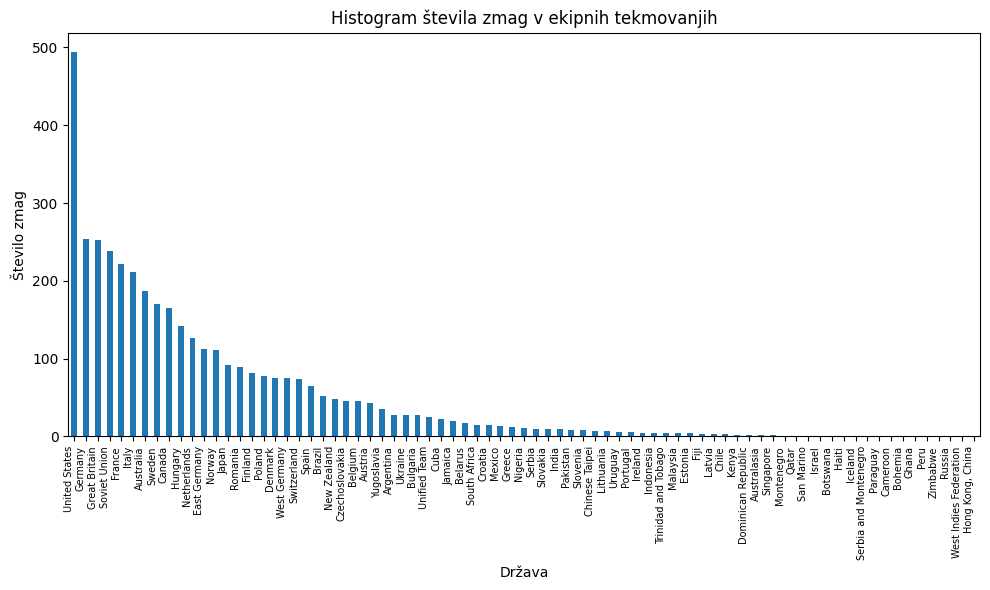

In [9]:

ekipna_tekmovanja = df[df['Winner'] == df['Committee']]

# Preštejemo število zmag glede na državo
stevilo_zmag_na_drzavo = ekipna_tekmovanja['Winner'].value_counts()

plt.figure(figsize=(10, 6))
stevilo_zmag_na_drzavo.plot(kind='bar')
plt.title('Histogram števila zmag v ekipnih tekmovanjih')
plt.xlabel('Država')
plt.ylabel('Število zmag')
plt.xticks(ha='right', fontsize=7)
plt.tight_layout()
plt.show()

Opazimo, da so skoraj za 2x najboljše Zvezne države Amerike, pred Nemčijo in Združenim kraljestvom.

### 4. Najuspešnejši športnik

Tukaj bomo izključili vse ekipne discipline, tako da bomo dobili določenega posameznika.

In [10]:

zmagovalci = df['Winner'].unique()

drzave = df['Committee'].unique()

izloceni_zmagovalci = []

for zmagovalec in zmagovalci:
    for drzava in drzave:
        for beseda in drzava.split():
            if beseda in zmagovalec.split():
                izloceni_zmagovalci.append(zmagovalec)
                break
                

zmagovalci_brez_podniza = df[~df['Winner'].isin(izloceni_zmagovalci)]

stevilo_medalj_na_zmagovalca = zmagovalci_brez_podniza['Winner'].value_counts()
print("Najuspešnejši olimpijec: ", stevilo_medalj_na_zmagovalca.idxmax())

Najuspešnejši olimpijec:  Michael Phelps


Najuspešnejši olimpijec vseh časov je torej znani plavalec Michael Phelps.

###  5. Najuspešnjše drzave

Hočemo izvedti, katere države, imajo največje število kolajn.

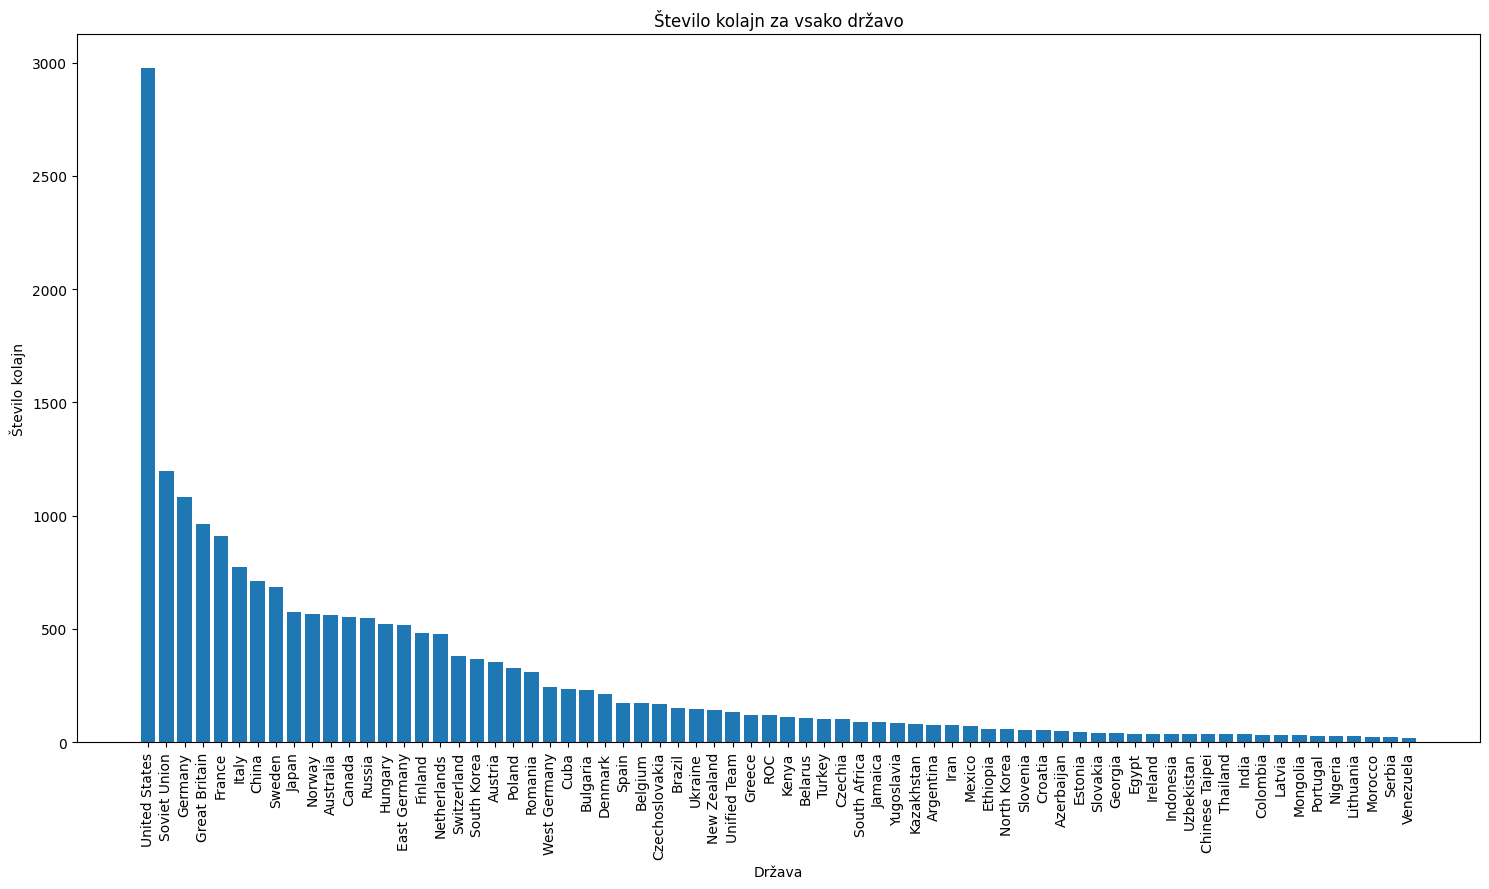

In [11]:
country_medal_counts = df['Committee'].value_counts().reset_index()
country_medal_counts.columns = ['Država', 'Število_kolajn']

country_medal_counts_sorted = country_medal_counts.sort_values(by='Število_kolajn', ascending=False).head(70)
country_medal_counts_sorted['Država'] = country_medal_counts_sorted['Država'].replace('ROC from the abbreviation for Russian Olympic Committee', 'ROC')

plt.figure(figsize=(15, 9))
plt.bar(country_medal_counts_sorted['Država'], country_medal_counts_sorted['Število_kolajn'])
plt.xlabel('Država')
plt.ylabel('Število kolajn')
plt.title('Število kolajn za vsako državo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Sedaj hočemo, še izvdedti, kolikokrat so države dobile kolajno v različnih disciplinah.

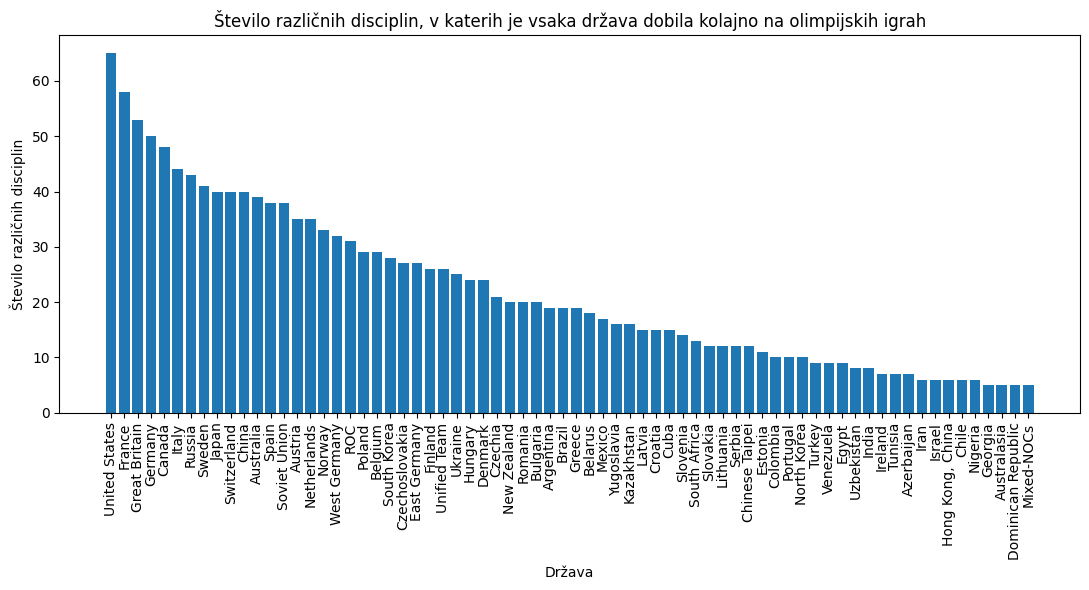

In [12]:

discipline_counts = df.groupby(['Committee', 'Discipline'])['Winner'].nunique().reset_index()
country_discipline_counts = discipline_counts.groupby('Committee').size().reset_index(name='Number_of_Disciplines')
country_discipline_counts = country_discipline_counts.sort_values(by='Number_of_Disciplines', ascending=False).head(70)

country_discipline_counts['Committee'] = country_discipline_counts['Committee'].replace('ROC from the abbreviation for Russian Olympic Committee', 'ROC')

plt.figure(figsize=(11, 6))
plt.bar(country_discipline_counts['Committee'], country_discipline_counts['Number_of_Disciplines'])
plt.xlabel('Država')
plt.ylabel('Število različnih disciplin')
plt.title('Število različnih disciplin, v katerih je vsaka država dobila kolajno na olimpijskih igrah')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Tukaj je veliko korelacije z številom zmag, ampak se je vrstni red rahlo premaknil.

Sedaj pa želimo, še izvedeti, katera država, ima nejveč zlatih medalj.

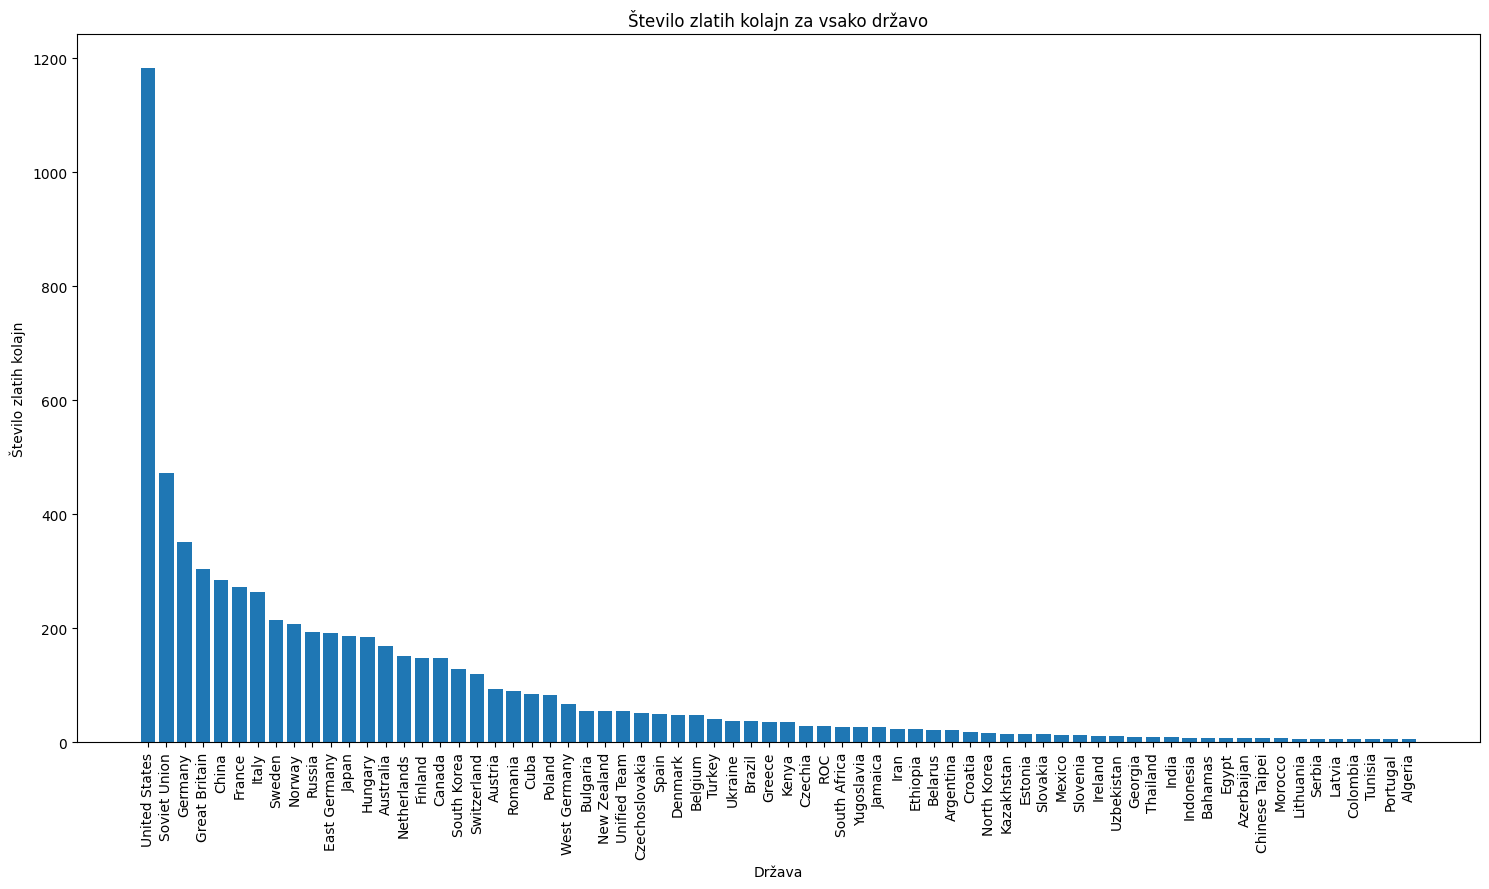

In [13]:
gold_medals_df = df[df['Medal_type'] == 'Gold']
country_gold_medal_counts = gold_medals_df['Committee'].value_counts().reset_index()
country_gold_medal_counts.columns = ['Država', 'Število_zlatih_kolajn']

country_gold_medal_counts_sorted = country_gold_medal_counts.sort_values(by='Število_zlatih_kolajn', ascending=False).head(70)
country_gold_medal_counts_sorted['Država'] = country_gold_medal_counts_sorted['Država'].replace('ROC from the abbreviation for Russian Olympic Committee', 'ROC')

plt.figure(figsize=(15, 9))
plt.bar(country_gold_medal_counts_sorted['Država'], country_gold_medal_counts_sorted['Število_zlatih_kolajn'])
plt.xlabel('Država')
plt.ylabel('Število zlatih kolajn')
plt.title('Število zlatih kolajn za vsako državo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Ta graf je skoraj identičen z grafom števila vseh medalj.

In [14]:

country_total_medal_counts = df['Committee'].value_counts().reset_index()
country_total_medal_counts.columns = ['Država', 'Skupno_kolajn']

gold_medals_df = df[df['Medal_type'] == 'Gold']
country_gold_medal_counts = gold_medals_df['Committee'].value_counts().reset_index()
country_gold_medal_counts.columns = ['Država', 'Število_zlatih_kolajn']
country_medal_info = pd.merge(country_total_medal_counts, country_gold_medal_counts, on='Država', how='left')

country_medal_info['Odstotek_zlatih'] = (country_medal_info['Število_zlatih_kolajn'] / country_medal_info['Skupno_kolajn']) * 100
country_medal_info_sorted = country_medal_info.sort_values(by='Odstotek_zlatih', ascending=False).head()

for index, row in country_medal_info_sorted.iterrows():
    print(f"Država: {row['Država']}, Skupno število medalj: {row['Skupno_kolajn']}, Število zlatih medalj: {int(row['Število_zlatih_kolajn'])}, Odstotek zlatih medalj: {row['Odstotek_zlatih']:.2f}%")

Država: Kosovo, Skupno število medalj: 3, Število zlatih medalj: 3, Odstotek zlatih medalj: 100.00%
Država: Fiji, Skupno število medalj: 3, Število zlatih medalj: 2, Odstotek zlatih medalj: 66.67%
Država: Ecuador, Skupno število medalj: 5, Število zlatih medalj: 3, Odstotek zlatih medalj: 60.00%
Država: Bermuda, Skupno število medalj: 2, Število zlatih medalj: 1, Odstotek zlatih medalj: 50.00%
Država: Suriname, Skupno število medalj: 2, Število zlatih medalj: 1, Odstotek zlatih medalj: 50.00%


### 6. Slovenija

Ker je bila Slovenija prej še pod Jugoslavijo, se ji lahko prišteje tudi medalje iz Jugoslavije.

In [15]:

slovenia_medals = df[df['Committee'].str.contains('Slovenia|Yugoslavia', case=False)]
total_slovenia_medals = slovenia_medals.shape[0]
print(f"Skupno število medalj, ki jih je Slovenija, vključno z Jugoslavijo, dobila: {total_slovenia_medals}")

Skupno število medalj, ki jih je Slovenija, vključno z Jugoslavijo, dobila: 139


Sedaj pa še koliko, medalj je Slovenija osvojila po osamosvojitvi.

In [16]:

slovenia_medals_only = slovenia_medals[slovenia_medals['Committee'].str.contains('Slovenia', case=False)]
total_slovenia_medals_only = slovenia_medals_only.shape[0]
print(f"Skupno število medalj, ki jih je Slovenija pridobila (brez Jugoslavije): {total_slovenia_medals_only}")

Skupno število medalj, ki jih je Slovenija pridobila (brez Jugoslavije): 52


Sedaj pa še porazdelitev medalj.

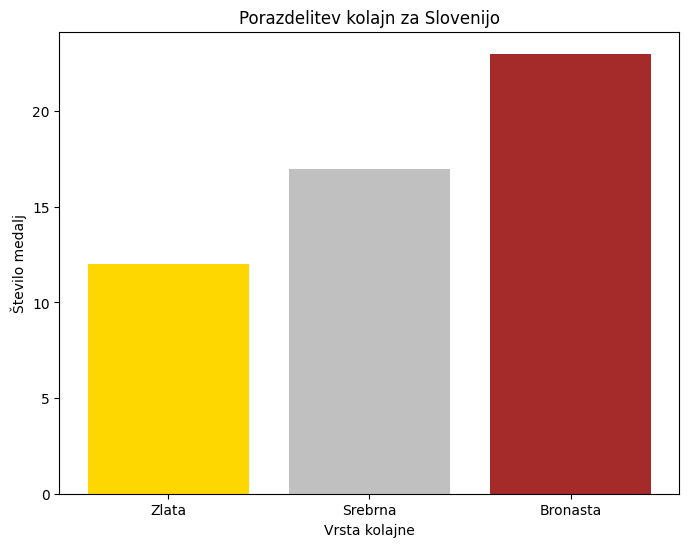

In [17]:
slovenia_medals = df[df['Committee'].str.contains('Slovenia', case=False)]
gold_count = slovenia_medals[slovenia_medals['Medal_type'] == 'Gold'].shape[0]
silver_count = slovenia_medals[slovenia_medals['Medal_type'] == 'Silver'].shape[0]
bronze_count = slovenia_medals[slovenia_medals['Medal_type'] == 'Bronze'].shape[0]
labels = ['Zlata', 'Srebrna', 'Bronasta']
counts = [gold_count, silver_count, bronze_count]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['gold', 'silver', 'brown'])
plt.xlabel('Vrsta kolajne')
plt.ylabel('Število medalj')
plt.title('Porazdelitev kolajn za Slovenijo')
plt.show()


Vidimo, da ima Slovenija najmanj zlatih in največ bronastih kolajn.

In [18]:
total_slovenia_medals = slovenia_medals.shape[0]
gold_percentage = (gold_count / total_slovenia_medals) * 100
print(f"Odstotek zlatih medalj za Slovenijo: {gold_percentage:.2f}%")

Odstotek zlatih medalj za Slovenijo: 23.08%


In [19]:
index_slovenia = country_medal_info[country_medal_info['Država'].str.contains('Slovenia', case=False)].index[0]
mesto_slovenia = index_slovenia + 1 
print(f"Mesto Slovenije po odstotku zlatih medalj: {mesto_slovenia}")

Mesto Slovenije po odstotku zlatih medalj: 50


### 7. Napovedovanje

Sedaj lahko, še poskušamo napovedati, koloko medalj, bo dobila posamezna država v naslednjih olimpijskih igrah.

In [ ]:

df_gold = df[df['Medal_type'] == 'Gold']

X = df_gold[['Olympic_year', 'Code']]  

gold_medals_per_country = df_gold.groupby('Code').size().reset_index(name='Gold_Medals')

X = pd.merge(X, gold_medals_per_country, on='Code', how='left')
y = X['Gold_Medals']
X = X.drop(columns=['Gold_Medals'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X = pd.get_dummies(X, columns=['Code'], drop_first=True)
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

X = X.dropna()
y = y[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.GLM(y_train.astype(float), sm.add_constant(X_train.astype(float)), family=sm.families.NegativeBinomial())
result = model.fit(method_kwargs={'warn_convergence': False})

next_games_data = df_gold[df_gold['Olympic_year'] >= 2020]
next_games_data_encoded = pd.get_dummies(next_games_data[['Olympic_year', 'Code']], columns=['Code'])
next_games_data_encoded = next_games_data_encoded.apply(pd.to_numeric, errors='coerce')
next_games_data_encoded = next_games_data_encoded.dropna()

missing_columns = set(X_train.columns) - set(next_games_data_encoded.columns)
for column in missing_columns:
    next_games_data_encoded[column] = 0

next_games_data_encoded = next_games_data_encoded[X_train.columns]

predictions = result.predict(sm.add_constant(next_games_data_encoded.astype(float)))
next_games_data['Predicted_Gold_Medals'] = predictions

seen_countries = set()  
count = 0 
sorted_data = next_games_data[['Code', 'Predicted_Gold_Medals']].sort_values(by='Predicted_Gold_Medals', ascending=False)
country_list = []
for index, row in sorted_data.iterrows():
    country = row['Code']
    predicted_medals = int(row['Predicted_Gold_Medals']) 
    if country not in seen_countries and count < 10:
        country_list.append((country, predicted_medals))
        seen_countries.add(country)
        count += 1 
    if count >= 10:
        break

In [21]:
print("Okrajšava | št. medalj")
for row in country_list:
    print(f"{row[0]:10s}| {row[1]}")

Okrajšava | št. medalj
USA       | 55
GER       | 53
GBR       | 52
CHN       | 51
FRA       | 50
ITA       | 49
SWE       | 48
NOR       | 47
JPN       | 44
HUN       | 43


Sedaj lahko še pogledamo, koliko zlatih medalj naj bi dobila Slovenija.

In [22]:
slovenia_row = next_games_data[next_games_data['Code'] == 'SLO']
slovenia_predicted_medals = slovenia_row['Predicted_Gold_Medals'].iloc[0] 
print('Število predvidenih zlatih medalj:', int(slovenia_predicted_medals))

Število predvidenih zlatih medalj: 10


In [23]:

slovenia_gold_medals_last_olympics = df[(df['Medal_type'] == 'Gold') & (df['Code'] == 'SLO') & (df['Olympic_year'] >= 2020)]
total_gold_medals_last_olympics = slovenia_gold_medals_last_olympics.shape[0]
print("Slovenija je zamgala ", total_gold_medals_last_olympics, "zlatih medalj v zadnjih poletnih olimpijskih igrah.")


Slovenija je zamgala  5 zlatih medalj v zadnjih poletnih olimpijskih igrah.


Lahko vidimo, da naj bi Slovenija, dobila 10 kolajn, medtem, ko je v zadnjih 4 letih zmagala samo 5.

In [24]:

football_data = df[(df['Event'] == 'Football, Men') & (df['Olympic_year'] >= 2000)]
X = football_data[['Olympic_year', 'Gender']]  
y = football_data['Winner']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = ['Gender']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])
model.fit(X_train, y_train)

next_olympic_year = 2024
next_olympic_gender = 'Men'  
next_input = pd.DataFrame({'Olympic_year': [next_olympic_year], 'Gender': [next_olympic_gender]})

predicted_probabilities = model.predict_proba(next_input)
predicted_probabilities_df = pd.DataFrame(predicted_probabilities, columns=model.classes_)

top_3_countries = predicted_probabilities_df.max().nlargest(3)

print("Prve tri države z največjo možnostjo zmage na naslednji olimpijadi v nogometu:")
for country, probability in top_3_countries.items():
    print(f"Država: {country}, Možnost zmage: {probability * 100:.2f}%")


Prve tri države z največjo možnostjo zmage na naslednji olimpijadi v nogometu:
Država: Brazil, Možnost zmage: 28.57%
Država: Spain, Možnost zmage: 14.28%
Država: Mexico, Možnost zmage: 14.28%


### 8. Razlika med zimskimi in poletnimi igrami

Začnemo lahko s tem, da pogledamo, koliko je bilo poletnih in koliko zimskih iger.

In [25]:
unique_olympiads = df[['Olympiad', 'Olympic_season']].drop_duplicates()
summer_count = (unique_olympiads['Olympic_season'] == 'summer').sum()
winter_count = (unique_olympiads['Olympic_season'] == 'winter').sum()
print("Število poletnih olimpijskih iger:", summer_count)
print("Število zimskih olimpijskih iger:", winter_count)

Število poletnih olimpijskih iger: 30
Število zimskih olimpijskih iger: 24


Sedaj nas pa še zanima, koliko tekmovanj je bilo v poletnih in koliko v zimskih.

In [26]:
summer_count = (df['Olympic_season'] == 'summer').sum()
winter_count = (df['Olympic_season'] == 'winter').sum()

print("Število poletnih olimpijskih iger:", summer_count)
print("Število zimskih olimpijskih iger:", winter_count)

Število poletnih olimpijskih iger: 16916
Število zimskih olimpijskih iger: 3496


V poletnih je bilo veliko več tekmovanj, kot pa v zimskih.

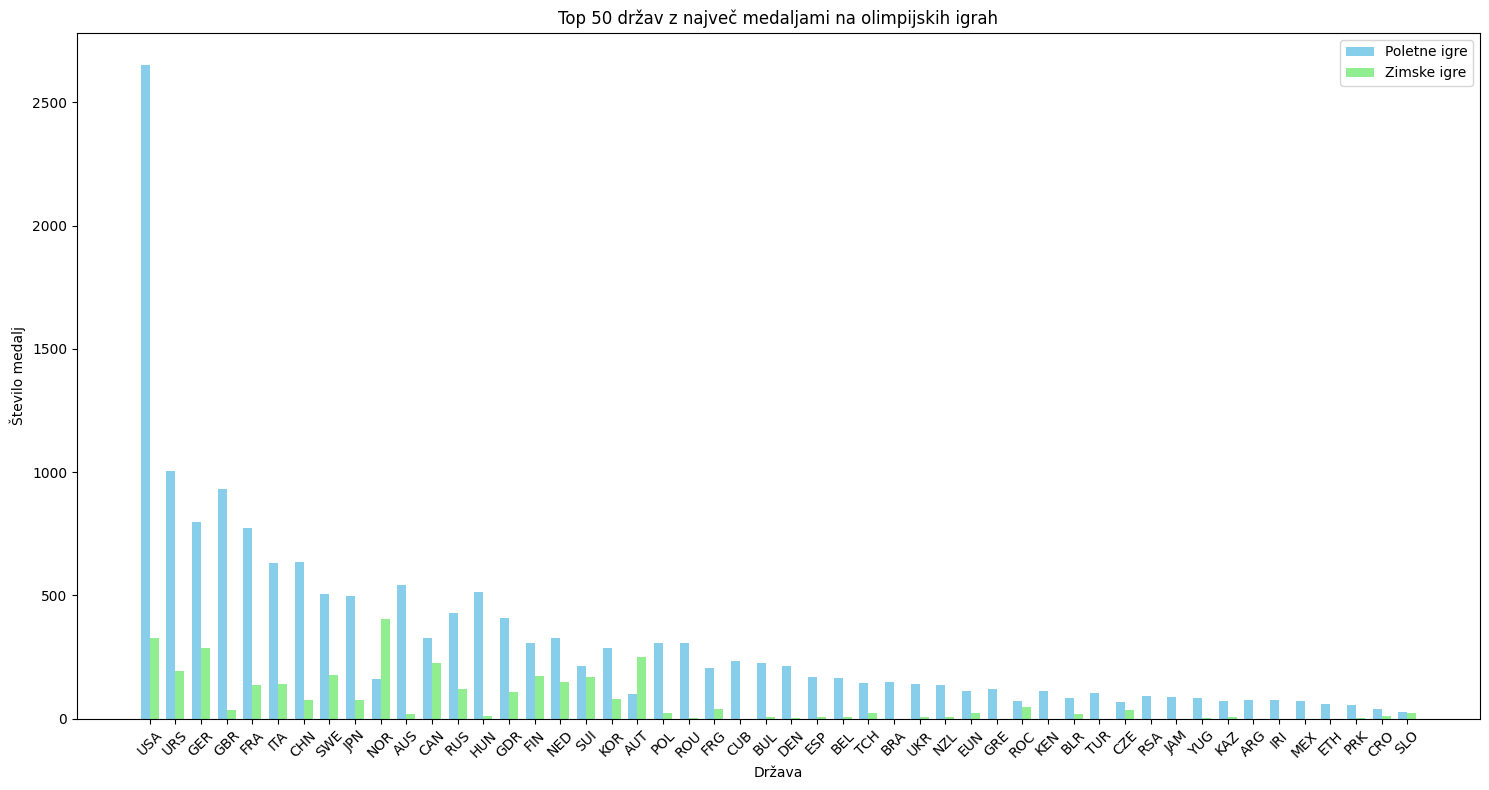

In [27]:

medals_per_country_season_type = df.groupby(['Code', 'Olympic_season', 'Medal_type']).size().reset_index(name='Medal_count')

summer_medals = medals_per_country_season_type[medals_per_country_season_type['Olympic_season'] == 'summer']
winter_medals = medals_per_country_season_type[medals_per_country_season_type['Olympic_season'] == 'winter']

countries = df['Code'].unique()

summer_medals_count = []
for country in countries:
    country_summer_medals = summer_medals[summer_medals['Code'] == country]['Medal_count'].sum()
    summer_medals_count.append(country_summer_medals)

winter_medals_count = []
for country in countries:
    country_winter_medals = winter_medals[winter_medals['Code'] == country]['Medal_count'].sum()
    winter_medals_count.append(country_winter_medals)

data = {'Country': countries, 'Summer_Medals': summer_medals_count, 'Winter_Medals': winter_medals_count}
country_df = pd.DataFrame(data)

country_df['Total_Medals'] = country_df['Summer_Medals'] + country_df['Winter_Medals']

country_df_sorted = country_df.sort_values(by='Total_Medals', ascending=False)

top_50_countries = country_df_sorted.head(50)
fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.35

index = np.arange(len(top_50_countries))
rects1 = ax.bar(index, top_50_countries['Summer_Medals'], bar_width, label='Poletne igre', color='skyblue')
rects2 = ax.bar(index + bar_width, top_50_countries['Winter_Medals'], bar_width, label='Zimske igre', color='lightgreen')

ax.set_xlabel('Država')
ax.set_ylabel('Število medalj')
ax.set_title('Top 50 držav z največ medaljami na olimpijskih igrah')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(top_50_countries['Country'])
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Vidimo lahko, da večina držav ima več mealj v poletnih igrah, z izjemo Norveške ter Avstrije. Slovenija ima skoraj enako število, za obe.

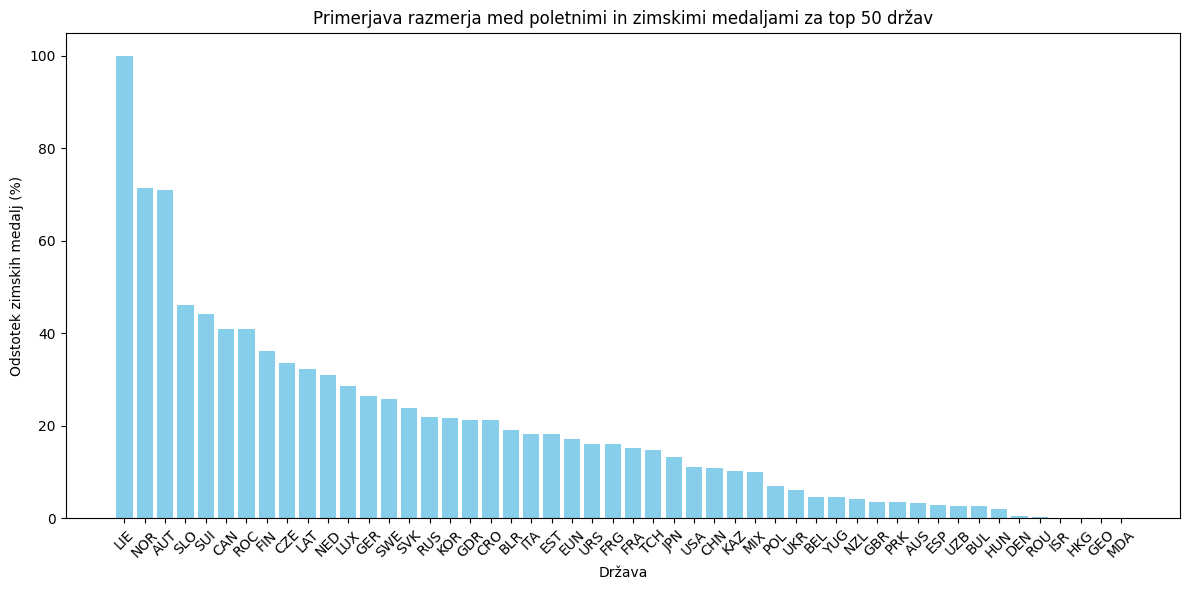

In [28]:
medals_per_country_season_type = df.groupby(['Code', 'Olympic_season', 'Medal_type']).size().reset_index(name='Medal_count')

summer_medals = medals_per_country_season_type[medals_per_country_season_type['Olympic_season'] == 'summer']
winter_medals = medals_per_country_season_type[medals_per_country_season_type['Olympic_season'] == 'winter']

countries = df['Code'].unique()

country_medals_comparison = {'Country': [], 'Percentage': []}

for country in countries:
    summer_medals_count = summer_medals[(summer_medals['Code'] == country) & (summer_medals['Medal_type'] != 'N')]['Medal_count'].sum()
    winter_medals_count = winter_medals[(winter_medals['Code'] == country) & (winter_medals['Medal_type'] != 'N')]['Medal_count'].sum()
    total_medals_count = summer_medals_count + winter_medals_count
    if total_medals_count > 0:
        percentage = (winter_medals_count / total_medals_count) * 100
        country_medals_comparison['Country'].append(country)
        country_medals_comparison['Percentage'].append(percentage)

comparison_df = pd.DataFrame(country_medals_comparison)
comparison_df_sorted = comparison_df.sort_values(by='Percentage', ascending=False)
top_50_countries = comparison_df_sorted.head(50)

plt.figure(figsize=(12, 6))
plt.bar(top_50_countries['Country'], top_50_countries['Percentage'], color='skyblue')
plt.title('Primerjava razmerja med poletnimi in zimskimi medaljami za top 50 držav')
plt.xlabel('Država')
plt.ylabel('Odstotek zimskih medalj (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

V tem grafu, je razvidno, da večino medalj je bilo podeljenih poleti in se tudi vidi, da ima Slovenija skoraj 50% zimskih medalj.

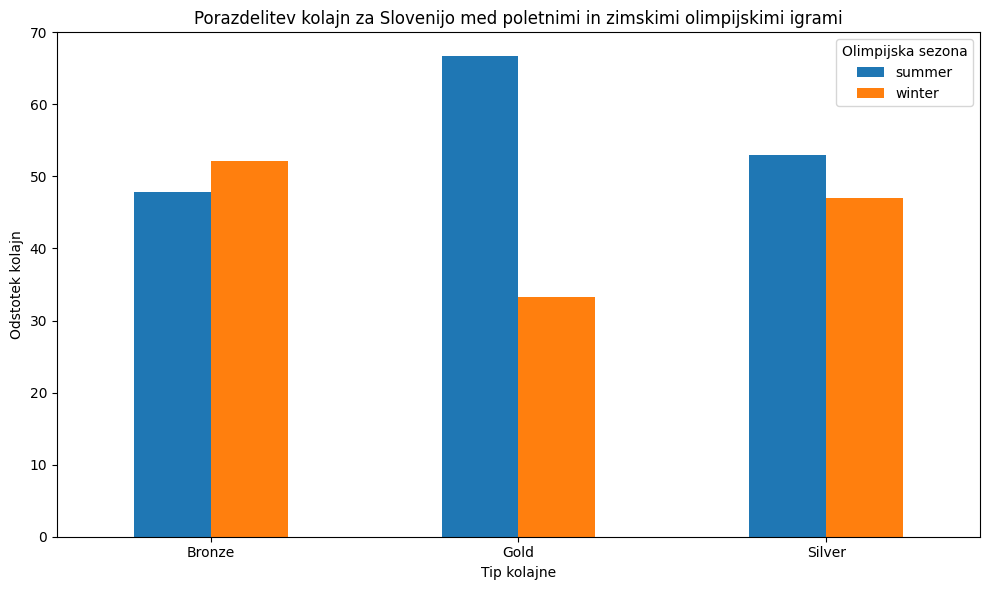

In [29]:
slovenia_medals = df[df['Code'] == 'SLO']
medals_distribution = slovenia_medals.groupby(['Medal_type', 'Olympic_season']).size().unstack(fill_value=0)

medals_distribution_percentage = medals_distribution.div(medals_distribution.sum(axis=1), axis=0) * 100


medals_distribution_percentage.plot(kind='bar', figsize=(10, 6))
plt.title('Porazdelitev kolajn za Slovenijo med poletnimi in zimskimi olimpijskimi igrami')
plt.xlabel('Tip kolajne')
plt.ylabel('Odstotek kolajn')
plt.xticks(rotation=0)
plt.legend(title='Olimpijska sezona')
plt.tight_layout()
plt.show()

### 9. Porazdelitev medalj po državah

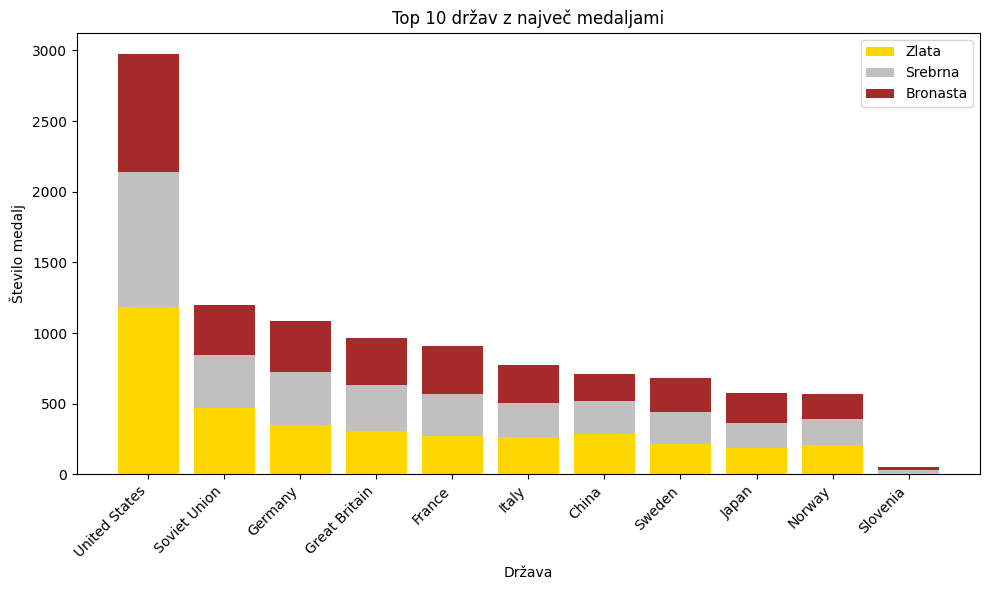

In [30]:

country_medals = df.groupby('Committee')['Medal_type'].value_counts().unstack().fillna(0)

country_medals['Total'] = country_medals.sum(axis=1)
top_10 = country_medals.sort_values(by='Total', ascending=False).head(10)

top_10_labels = top_10.index
top_10_counts = top_10[['Gold', 'Silver', 'Bronze']].values.T

slovenia_counts = country_medals.loc['Slovenia', ['Gold', 'Silver', 'Bronze']]

plt.figure(figsize=(10, 6))
plt.bar(top_10_labels, top_10_counts[0], color='gold', label='Zlata')
plt.bar(top_10_labels, top_10_counts[1], bottom=top_10_counts[0], color='silver', label='Srebrna')
plt.bar(top_10_labels, top_10_counts[2], bottom=top_10_counts[0]+top_10_counts[1], color='brown', label='Bronasta')
plt.bar('Slovenia', slovenia_counts['Gold'], color='gold')
plt.bar('Slovenia', slovenia_counts['Silver'], bottom=slovenia_counts['Gold'], color='silver')
plt.bar('Slovenia', slovenia_counts['Bronze'], bottom=slovenia_counts['Gold']+slovenia_counts['Silver'], color='brown')
plt.xlabel('Država')
plt.ylabel('Število medalj')
plt.title('Top 10 držav z največ medaljami')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

V tem grafu je razvidno, da je v uspešnješih državah, porazdelitev koljan skoraj enakomerna.

### 10. Število medalj na milijon prebivalcev

Seveda pa ne moremo enačiti dosežke večje države, z manjšo, zato lahko tudi preverimo število koljan na miljon prebivalcev.

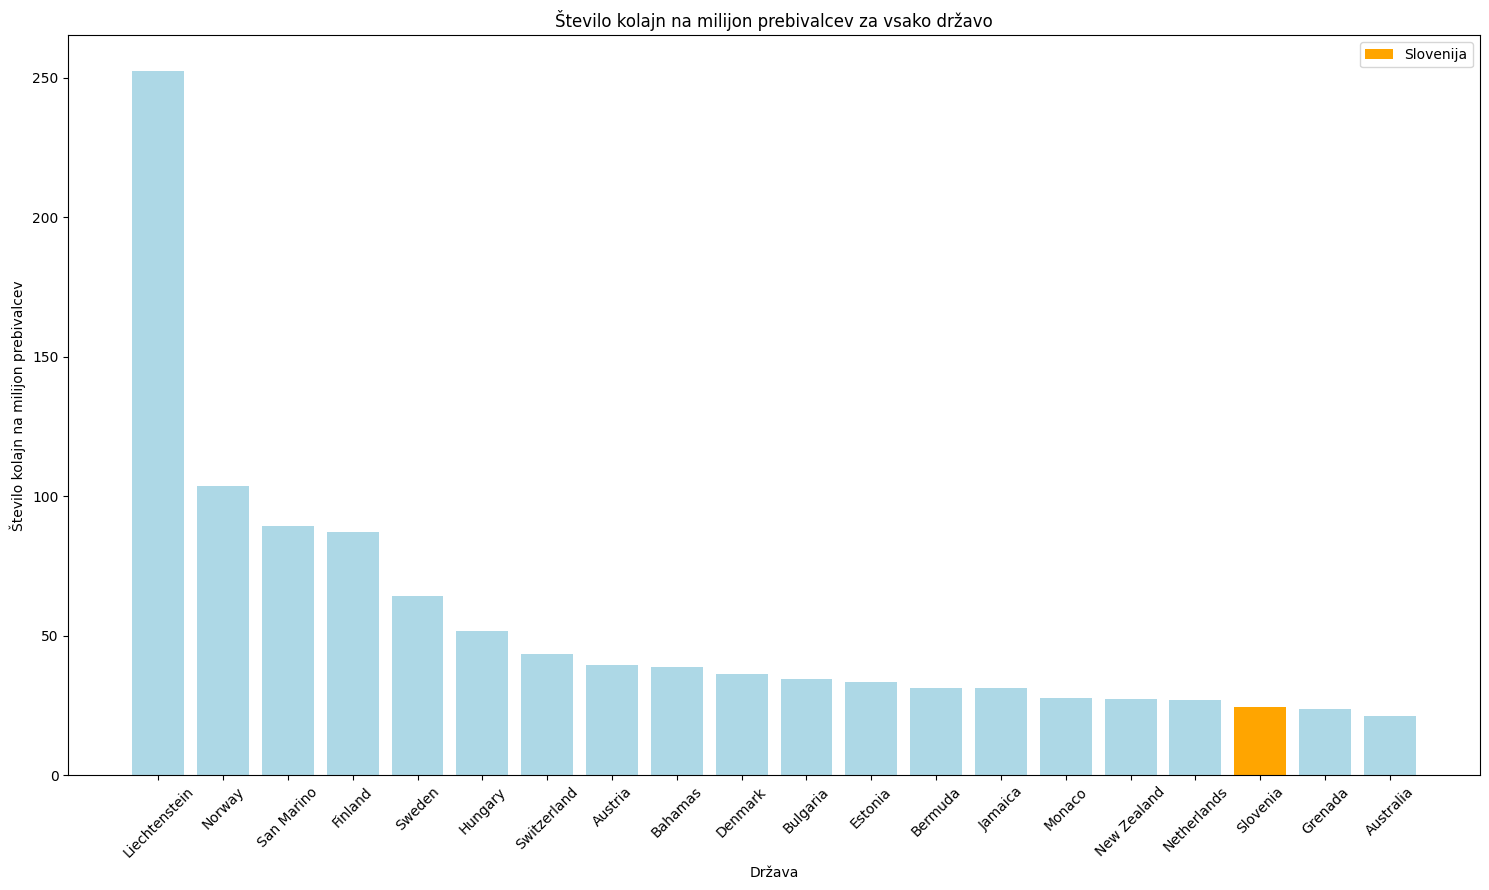

In [31]:

population_data = df_population[['country', 'pop2023']]


population_dict = population_data.set_index('country')['pop2023'].to_dict()

country_medal_counts = df['Committee'].value_counts().reset_index()
country_medal_counts.columns = ['Država', 'Število_kolajn']

country_medal_counts_sorted = country_medal_counts.sort_values(by='Število_kolajn', ascending=False)
country_medal_counts_sorted['Država'] = country_medal_counts_sorted['Država'].replace('ROC from the abbreviation for Russian Olympic Committee', 'ROC')

country_medal_counts_sorted_filtered = country_medal_counts_sorted[country_medal_counts_sorted['Država'].isin(population_dict.keys())].copy()

country_medal_counts_sorted_filtered['Populacija'] = country_medal_counts_sorted_filtered['Država'].map(population_dict)

country_medal_counts_sorted_filtered['Kolajne_na_milijon_prebivalcev'] = (country_medal_counts_sorted_filtered['Število_kolajn'] / country_medal_counts_sorted_filtered['Populacija']) * 1000000

country_medal_counts_sorted_filtered = country_medal_counts_sorted_filtered.sort_values(by='Kolajne_na_milijon_prebivalcev', ascending=False)

top_20_filtered = country_medal_counts_sorted_filtered.head(20)

# Pripravimo barve za vsako državo, pri čemer je Slovenija oranžna
colors = ['orange' if country == 'Slovenia' else 'lightblue' for country in top_20_filtered['Država']]

plt.figure(figsize=(15, 9))
bars = plt.bar(top_20_filtered['Država'], top_20_filtered['Kolajne_na_milijon_prebivalcev'], color=colors)
plt.xlabel('Država')
plt.ylabel('Število kolajn na milijon prebivalcev')
plt.title('Število kolajn na milijon prebivalcev za vsako državo')
plt.xticks(rotation=45)
plt.tight_layout()

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor='orange', label='Slovenija')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

Liechtenstein je glede na število prebivalcev daleč najuspešnejša država, saj ima kar 252 kolajn na milijon prebivalcev. Slovenija je na odličnem 18. mestu z 24 medaljami na milijon prebivalcev.

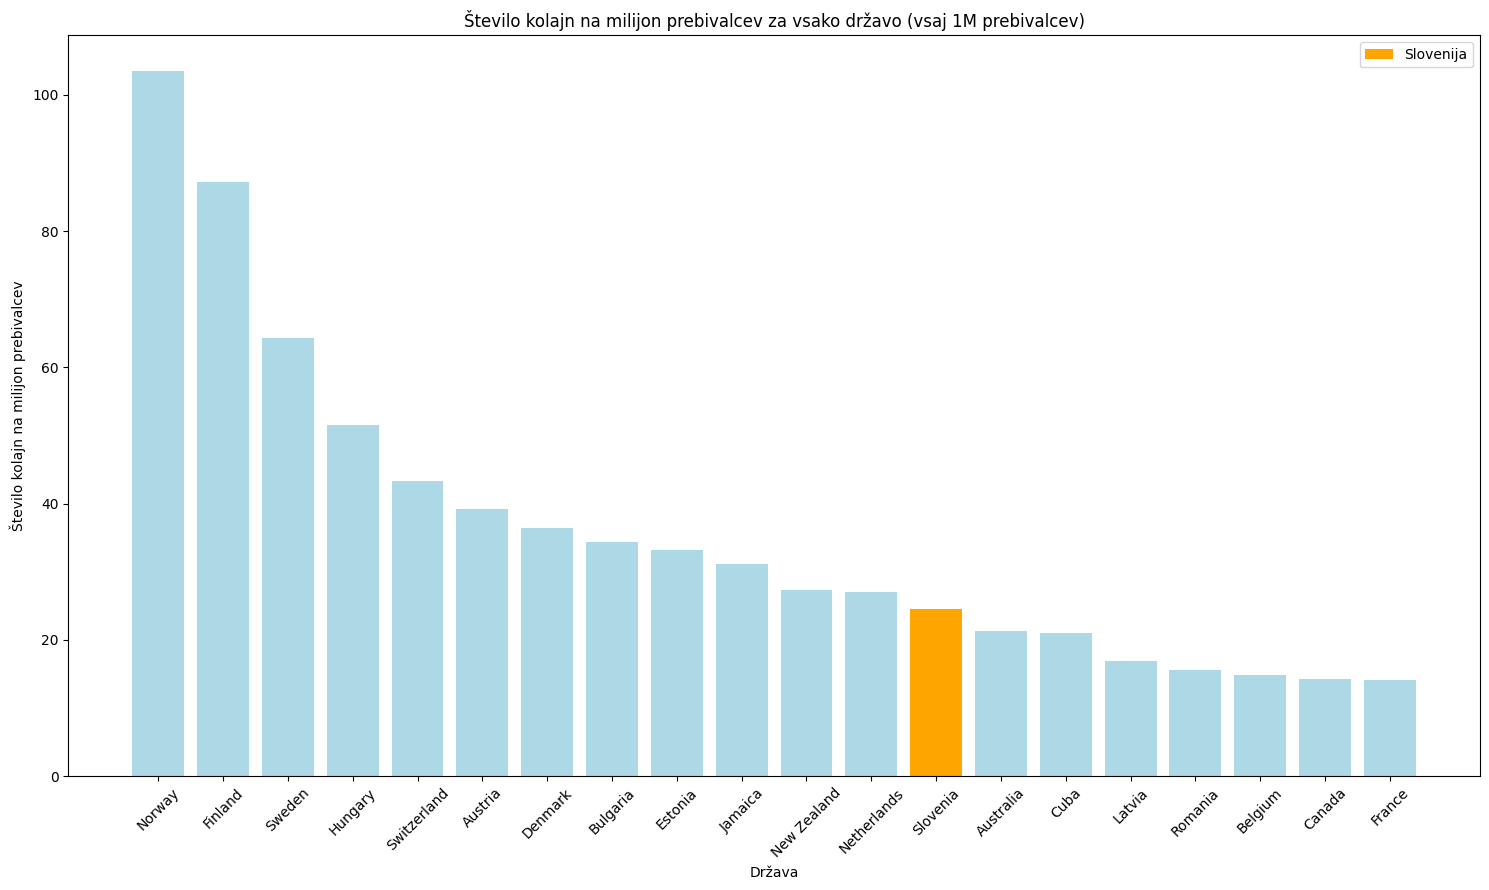

In [32]:

country_medal_counts_sorted_filtered = country_medal_counts_sorted[country_medal_counts_sorted['Država'].isin(population_dict.keys())].copy()
country_medal_counts_sorted_filtered = country_medal_counts_sorted_filtered[country_medal_counts_sorted_filtered['Država'].map(population_dict) >= 1e6]

# Izračunamo število prebivalcev za filtrirane države
country_medal_counts_sorted_filtered['Populacija'] = country_medal_counts_sorted_filtered['Država'].map(population_dict)
country_medal_counts_sorted_filtered['Kolajne_na_milijon_prebivalcev'] = (country_medal_counts_sorted_filtered['Število_kolajn'] / country_medal_counts_sorted_filtered['Populacija']) * 1000000
country_medal_counts_sorted_filtered = country_medal_counts_sorted_filtered.sort_values(by='Kolajne_na_milijon_prebivalcev', ascending=False)

top_20_filtered = country_medal_counts_sorted_filtered.head(20)

# Pripravimo barve za vsako državo, pri čemer je Slovenija oranžna
colors = ['orange' if country == 'Slovenia' else 'lightblue' for country in top_20_filtered['Država']]

plt.figure(figsize=(15, 9))
bars = plt.bar(top_20_filtered['Država'], top_20_filtered['Kolajne_na_milijon_prebivalcev'], color=colors)
plt.xlabel('Država')
plt.ylabel('Število kolajn na milijon prebivalcev')
plt.title('Število kolajn na milijon prebivalcev za vsako državo (vsaj 1M prebivalcev)')
plt.xticks(rotation=45)
plt.tight_layout()

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='orange', label='Slovenija')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()


Če pa gledamo države, ki imajo vsaj milijon prebivalcev, se SLovenija povzpne na 13. mesto.